# Filtering, reformatting and adding metadata to variants

This notebook includes the first steps of downstream processing for vcf files generated with freebayes (https://github.com/ekg/freebayes), filtered with vcffilter and annotated with SnpEff. The input files are tab delimited text files generated from annotated vcf files using SnpSift, with only the first annotation for each variant considered. The processing includes reformatting data tables, filtering variants and adding metadata to create a master data table containing a golden set of variants.

In [1]:
# Housekeeping

library(ggplot2)
library(reshape2)

In [2]:
# Read in variant data (SNPs, MNPs and indels)

files = list.files("../../../data/deep_seq/variant_data/", full.names = T)
filenames = gsub("_SnpSift.txt", "", basename(files))
variant_list = lapply(files, read.table,header = T, check.names = F)
names(variant_list) = filenames
head(variant_list[[1]])

CHROM,POS,REF,ALT,TYPE,ANN[0].EFFECT,ANN[0].IMPACT,ANN[0].GENE,ANN[0].GENEID,ANN[0].HGVS_C,ANN[0].HGVS_P,GEN[*].AD
IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.834T>C,p.Gly278Gly,"NA:NA:NA:NA:NA:NA:NA:NA:10,11:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:0,1:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA"
IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.792T>C,p.Asp264Asp,"NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:1,5:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:2,4:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA"
IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.744_747delTTCTinsCTCG,p.ThrSer248ThrSer,"NA:NA:NA:NA:NA:NA:NA:5,6:6,7:NA:NA:2,4:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:2,2:1,1:NA:NA:1,6:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA"
IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.510G>A,p.Ala170Ala,"NA:NA:NA:NA:NA:NA:3,6:NA:6,7:NA:NA:2,3:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:3,3:NA:0,2:NA:NA:1,6:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA"
IDIPBEOP_1,1145348,G,C,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.432C>G,p.Leu144Leu,"NA:NA:NA:NA:NA:NA:5,10:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:3,3:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA"
IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.351_357delCGCCCGTinsTGCTCGC,p.LeuAlaArg117LeuAlaArg,"NA:NA:NA:NA:NA:NA:3,10:NA:NA:NA:1,3:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:1,2:NA:NA:NA:4,4:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA:NA"


In [3]:
# Split genotype column by sample and add sample id (based on vcf header)

variant_list2 = list()
for(i in 1:length(variant_list)){
  a = variant_list[[i]]
  b = data.frame(do.call('rbind', strsplit(as.character(a$`GEN[*].AD`), ':', fixed = TRUE)))
  colnames(b) = c("T12_AB0_I0_REP1", 
                  "T12_AB0_I0_REP2", 
                  "T12_AB0_I0_REP3", 
                  "T12_AB0_I1_REP1", 
                  "T12_AB0_I1_REP2", 
                  "T12_AB0_I1_REP3", 
                  "T12_AB128_I0_REP1", 
                  "T12_AB128_I0_REP2", 
                  "T12_AB128_I0_REP3", 
                  "T12_AB128_I1_REP1", 
                  "T12_AB128_I1_REP2", 
                  "T12_AB128_I1_REP3", 
                  "T12_AB16_I0_REP1", 
                  "T12_AB16_I0_REP2", 
                  "T12_AB16_I0_REP3", 
                  "T12_AB16_I1_REP1", 
                  "T12_AB16_I1_REP2", 
                  "T12_AB16_I1_REP3", 
                  "T12_AB4_I0_REP1", 
                  "T12_AB4_I0_REP2", 
                  "T12_AB4_I0_REP3", 
                  "T12_AB4_I1_REP1", 
                  "T12_AB4_I1_REP2", 
                  "T12_AB4_I1_REP3", 
                  "T8_AB0_I0_REP1", 
                  "T8_AB0_I0_REP2", 
                  "T8_AB0_I0_REP3", 
                  "T8_AB0_I1_REP1", 
                  "T8_AB0_I1_REP2", 
                  "T8_AB0_I1_REP3", 
                  "T8_AB128_I0_REP1", 
                  "T8_AB128_I0_REP2", 
                  "T8_AB128_I0_REP3", 
                  "T8_AB128_I1_REP1", 
                  "T8_AB128_I1_REP2", 
                  "T8_AB128_I1_REP3", 
                  "T8_AB16_I0_REP1", 
                  "T8_AB16_I0_REP2", 
                  "T8_AB16_I0_REP3",
                  "T8_AB16_I1_REP1", 
                  "T8_AB16_I1_REP2", 
                  "T8_AB16_I1_REP3", 
                  "T8_AB4_I0_REP1", 
                  "T8_AB4_I0_REP2", 
                  "T8_AB4_I0_REP3", 
                  "T8_AB4_I1_REP1", 
                  "T8_AB4_I1_REP2", 
                  "T8_AB4_I1_REP3")
  a = cbind(a[, -12], b)
  variant_list2[[i]] = a
}
names(variant_list2)=filenames

head(variant_list2[[1]])

CHROM,POS,REF,ALT,TYPE,ANN[0].EFFECT,ANN[0].IMPACT,ANN[0].GENE,ANN[0].GENEID,ANN[0].HGVS_C,⋯,T8_AB16_I0_REP3,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3
IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.834T>C,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.792T>C,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.744_747delTTCTinsCTCG,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.510G>A,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
IDIPBEOP_1,1145348,G,C,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.432C>G,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.351_357delCGCCCGTinsTGCTCGC,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [4]:
# Convert read count data to proportions and modify column names

options(warn = -1) # inactivate warnings to avoid NA alerts

dim(variant_list2[[1]])
variant_list3 = list()
for(i in 1:length(variant_list2)){
  a = variant_list2[[i]]
  for(k in 1:48){
    c = vector(mode = "numeric", length = length(a[, 11 + k]))
    for(j in 1:nrow(a)){
      b = as.character(a[j, 11+k])
      b = as.numeric(unlist(strsplit(b, ",", fixed = T)))
      b = ifelse(is.na(b) == T, NA, b[2] / sum(b))
      c[j] = b
      }
    a[, 11 + k] = c
    a[, 11 + k] = as.numeric(a[, 11 + k])
    names(a) = gsub("[ANN[0].]", "", names(a))
    names(a) = gsub("ANN.", "", names(a))
    a["SPECIES"] = paste("HAMBI", names(variant_list2[i]), sep = "_")
  }
  variant_list3[[i]] = a
}

options(warn = 0) # reactivate warnings

head(variant_list3[[1]])

[1] 31 59

CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,⋯,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3,SPECIES
IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.834T>C,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.792T>C,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.744_747delTTCTinsCTCG,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.510G>A,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1145348,G,C,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.432C>G,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.351_357delCGCCCGTinsTGCTCGC,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105


In [5]:
# Convert read count data to total read depth and modify column names

options(warn = -1) # inactivate warnings to avoid NA alerts

depth_list = list()
for(i in 1:length(variant_list2)){
  a = variant_list2[[i]]
  for(k in 1:48){
    c = vector(mode = "numeric", length = length(a[, 11+k]))
    for(j in 1:nrow(a)){
      b = as.character(a[j, 11 + k])
      b = as.numeric(unlist(strsplit(b, ",", fixed = T)))
      b = ifelse(is.na(b) == T, NA, sum(b))
      c[j] = b
    }
    a[, 11 + k] = c
    a[, 11 + k] = as.numeric(a[, 11+k])
    names(a) = gsub("[ANN[0].]", "", names(a))
    names(a) = gsub("ANN.", "", names(a))
    a["SPECIES"] = paste("HAMBI", names(variant_list2[i]), sep = "_")
  }
  depth_list[[i]] = a
}

options(warn = 0) # reactivate warnings

head(depth_list[[1]])

CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,⋯,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3,SPECIES
IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.834T>C,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.792T>C,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.744_747delTTCTinsCTCG,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.510G>A,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1145348,G,C,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.432C>G,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105
IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.351_357delCGCCCGTinsTGCTCGC,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,HAMBI_105


In [6]:
# Concatenate variant frequency list into data frame

variants=Reduce(function(...) merge(..., all=T), variant_list3)
variants=variants[,c(60, 1:59)] # move species to first column
head(variants)

SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,⋯,T8_AB16_I0_REP3,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3
HAMBI_105,IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1145348,G,C,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [7]:
# Concatenate variant depth list into data frame

depths=Reduce(function(...) merge(..., all=T), depth_list)
depths=depths[,c(60, 1:59)] # move species to first column
head(depths)

SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,⋯,T8_AB16_I0_REP3,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3
HAMBI_105,IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1145348,G,C,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
HAMBI_105,IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [8]:
# Add depth column to variants

tot_depth = rowSums(depths[, 13:60], na.rm = T)
variants$tot_depth = tot_depth
dim(variants)

[1] 132299     61

In [9]:
# Remove variants with combined depth over all samples < 10

variants = variants[variants$tot_depth >= 10,]
dim(variants) # 132299-132171 = 128 variants removed

[1] 132171     61

In [10]:
# Check that there are no 0 frequency rows

min(rowSums(variants[, 13:60]), na.rm = T) # ok

[1] 27.27505

In [11]:
# Inspect variant counts per species

table(variants$SPECIES) # other species have max. 309 variants while HAMBI 403 has over 130k variants


 HAMBI_105 HAMBI_1287 HAMBI_1874 HAMBI_1875 HAMBI_1896 HAMBI_1972 HAMBI_1977 
        31         74         29        106        145        176        309 
HAMBI_1992 HAMBI_2160 HAMBI_2443 HAMBI_2659 HAMBI_3031 HAMBI_3172  HAMBI_403 
         6         21         30        102         54        149     130939 

In [12]:
# Remove HAMBI 403 which likely has an unsuitable reference genome (taken from database based on strain identity)

variants = variants[variants$SPECIES != "HAMBI_403",]

In [13]:
# Count the number of observations for each variant

variants2 = variants[, 13:60]
variants2 = ifelse(is.na(variants2), 0, 1)
non_na_obs = rowSums(variants2)
variants$non_na_obs = non_na_obs
head(variants)

SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,⋯,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3,tot_depth,non_na_obs
HAMBI_105,IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,22,2
HAMBI_105,IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,12,2
HAMBI_105,IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,43,6
HAMBI_105,IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,42,6
HAMBI_105,IDIPBEOP_1,1145348,G,C,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,21,2
HAMBI_105,IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,NA,28,4


In [14]:
# Count the number of samples per species with variant data

a = unique(variants$SPECIES)
N_sample = setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("SPECIES", "N_sample"))
for(i in 1:length(a)){
  b = colSums(variants[variants$SPECIES == a[i], 13:60], na.rm = T)
  c = ifelse(b == 0 | is.na(b), 0, 1)
  d = sum(c)
  N_sample[i,"SPECIES"] = a[i]
  N_sample[i, "N_sample"] = d
}

variants = merge(variants, N_sample, all.x = T)
head(variants)

SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,⋯,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3,tot_depth,non_na_obs,N_sample
HAMBI_105,IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,22,2,32
HAMBI_105,IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,12,2,32
HAMBI_105,IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,43,6,32
HAMBI_105,IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,42,6,32
HAMBI_105,IDIPBEOP_1,1145348,G,C,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,21,2,32
HAMBI_105,IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,28,4,32


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


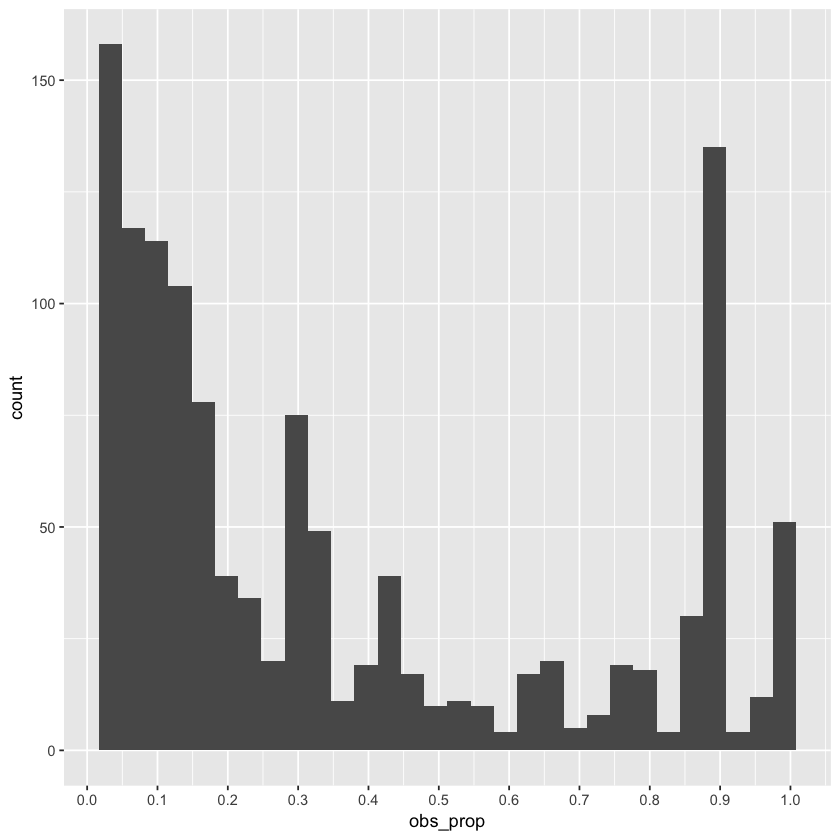

In [15]:
# Count and visualize the proportion of samples with an observation

variants$obs_prop = variants$non_na_obs / variants$N_sample

p1 = ggplot(variants, aes(x=obs_prop)) +
        geom_histogram() +
        scale_x_continuous(breaks = seq(0, 1, len = 11))
p1

In [16]:
# There are high peaks of variants occurring in over 80 % of samples, indicating that these might be ancestral variants or alignment errors
# Let's remove these

variants = variants[variants$obs_prop <= 0.8,]
nrow(variants) # 983 variants left

[1] 983

In [17]:
# Each community has two samples (for two time points), and only variants called in both were accepted in vcffilter
# Let's remove variants occurring in odd numbers of samples in case any remain

odds = seq(1, 48, 2)
variants2 = variants[!(variants$non_na_obs %in% odds),]
nrow(variants) - nrow(variants2) # 13 variants removed

[1] 13

In [18]:
# Reformat and add treatment information

variants2 = melt(variants2[,1:60], id.vars = c("SPECIES","CHROM","POS","REF","ALT","TYPE","EFFECT","IMPACT","GENE","GENEID","HGVS_C","HGVS_P"))
colnames(variants2) =  c("SPECIES","CHROM","POS","REF","ALT","TYPE","EFFECT","IMPACT","GENE","GENEID","HGVS_C","HGVS_P", "SAMPLE", "FREQUENCY")
variants2 = variants2[!is.na(variants2$FREQUENCY),]
variants2 = variants2[order(variants2$SPECIES, variants2$CHROM, variants2$POS),]
variants2$TIME = gsub("_AB.*", "", variants2$SAMPLE)
variants2$TIME = as.numeric(gsub("T", "", variants2$TIME))
variants2$AB = gsub(".*_AB", "", variants2$SAMPLE)
variants2$AB = as.numeric(gsub("_I.*", "", variants2$AB))
variants2$IM = gsub(".*_I", "", variants2$SAMPLE)
variants2$IM = as.factor(as.character(gsub("_REP.*", "", variants2$IM)))
variants2$REP = as.factor(as.character(gsub(".*_REP", "", variants2$SAMPLE)))
head(variants2)

,SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,SAMPLE,FREQUENCY,TIME,AB,IM,REP
7761,HAMBI_105,IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.834T>C,p.Gly278Gly,T12_AB128_I0_REP3,0.5238095,12,128,0,3
31041,HAMBI_105,IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.834T>C,p.Gly278Gly,T8_AB128_I0_REP3,1.0000000,8,128,0,3
10672,HAMBI_105,IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.792T>C,p.Asp264Asp,T12_AB128_I1_REP3,0.8333333,12,128,1,3
33952,HAMBI_105,IDIPBEOP_1,1144988,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.792T>C,p.Asp264Asp,T8_AB128_I1_REP3,0.6666667,8,128,1,3
6793,HAMBI_105,IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.744_747delTTCTinsCTCG,p.ThrSer248ThrSer,T12_AB128_I0_REP2,0.5454545,12,128,0,2
7763,HAMBI_105,IDIPBEOP_1,1145033,AGAA,CGAG,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.744_747delTTCTinsCTCG,p.ThrSer248ThrSer,T12_AB128_I0_REP3,0.5384615,12,128,0,3


In [19]:
# Add median genome coverage data per strain

# Read in data

deep_seq_comb = read.table('../../../data/deep_seq/median_coverage_per_1kb_window.txt', 
                           header = T, 
                           sep = '\t', 
                           check.names = F)

# Reformat

deep_seq_comb$TIME = gsub("_AB.*", "", deep_seq_comb$sample)
deep_seq_comb$TIME = as.numeric(gsub("T", "", deep_seq_comb$TIME))
deep_seq_comb$AB = gsub(".*_AB", "", deep_seq_comb$sample)
deep_seq_comb$AB = as.numeric(gsub("_I.*", "", deep_seq_comb$AB))
deep_seq_comb$IM = gsub(".*_I", "", deep_seq_comb$sample)
deep_seq_comb$IM = as.factor(as.character(gsub("_REP.*", "", deep_seq_comb$IM)))
deep_seq_comb$REP = gsub(".*_REP", "", deep_seq_comb$sample)
deep_seq_comb$SPECIES = paste("HAMBI", deep_seq_comb$strain, sep = "_")
deep_seq_comb = deep_seq_comb[,-c(1:2)]
colnames(deep_seq_comb) = c("MEDIAN_COV",
                            "TIME",
                            "AB",
                            "IM",
                            "REP",
                            "SPECIES")

# Extract only those species with variant data

deep_seq_comb = deep_seq_comb[deep_seq_comb$SPECIES %in% variants2$SPECIES,]

# Add coverage data to variant data table

variants3 = merge(variants2, deep_seq_comb)
head(variants3)

SPECIES,TIME,AB,IM,REP,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,SAMPLE,FREQUENCY,MEDIAN_COV
HAMBI_105,12,0,0,3,IDIPBEOP_6,237283,GC,TA,NA,synonymous_variant,LOW,cya,IDIPBEOP_03748,c.3171_3172delGCinsTA,p.LeuArg1057LeuArg,T12_AB0_I0_REP3,1.0000000,10
HAMBI_105,12,0,0,3,IDIPBEOP_6,237300,T,C,snp,missense_variant,MODERATE,cya,IDIPBEOP_03748,c.3188T>C,p.Val1063Ala,T12_AB0_I0_REP3,1.0000000,10
HAMBI_105,12,0,0,3,IDIPBEOP_6,237310,T,C,snp,synonymous_variant,LOW,cya,IDIPBEOP_03748,c.3198T>C,p.Asp1066Asp,T12_AB0_I0_REP3,1.0000000,10
HAMBI_105,12,128,0,1,IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.510G>A,p.Ala170Ala,T12_AB128_I0_REP1,0.6666667,74
HAMBI_105,12,128,0,1,IDIPBEOP_19,7480,T,C,snp,synonymous_variant,LOW,cspA_6,IDIPBEOP_05060,c.42T>C,p.Gly14Gly,T12_AB128_I0_REP1,0.9000000,74
HAMBI_105,12,128,0,1,IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.351_357delCGCCCGTinsTGCTCGC,p.LeuAlaArg117LeuAlaArg,T12_AB128_I0_REP1,0.7692308,74


In [20]:
# Add species abundance data (normalized to 15k reads) based on 16S rRNA gene amplicon analysis

# Read in data

amplicon_data = read.table('../../../data/amplicon/species_abundance.txt', 
                           header = T, 
                           sep = '\t', 
                           check.names = F)

# Reformat

amplicon_data = melt(amplicon_data, id.vars = "species")
colnames(amplicon_data) = c("SPECIES", "SAMPLE", "AMPLICON_READS")
amplicon_data$TIME = gsub("_AB.*", "", amplicon_data$SAMPLE)
amplicon_data$TIME = as.numeric(gsub("T", "", amplicon_data$TIME))
amplicon_data$AB = gsub(".*_AB", "", amplicon_data$SAMPLE)
amplicon_data$AB = as.numeric(gsub("_I.*", "", amplicon_data$AB))
amplicon_data$IM = gsub(".*_I", "", amplicon_data$SAMPLE)
amplicon_data$IM = as.factor(as.character(gsub("_REP.*", "", amplicon_data$IM)))
amplicon_data$REP = gsub(".*_REP", "", amplicon_data$SAMPLE)
amplicon_data$REP = as.factor(as.character(gsub("_all", "", amplicon_data$REP)))
amplicon_data$SPECIES = paste("HAMBI", amplicon_data$SPECIES, sep = "_")
amplicon_data = amplicon_data[,-2]

# Extract only those species with variant data

amplicon_data = amplicon_data[amplicon_data$SPECIES %in% variants3$SPECIES,]

# Add amplicon data to variant data table

variants4 = merge(variants3, amplicon_data, all.x = T)
head(variants4)

SPECIES,TIME,AB,IM,REP,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,SAMPLE,FREQUENCY,MEDIAN_COV,AMPLICON_READS
HAMBI_105,8,0,0,3,IDIPBEOP_6,237283,GC,TA,NA,synonymous_variant,LOW,cya,IDIPBEOP_03748,c.3171_3172delGCinsTA,p.LeuArg1057LeuArg,T8_AB0_I0_REP3,0.8181818,14,7
HAMBI_105,8,0,0,3,IDIPBEOP_6,237300,T,C,snp,missense_variant,MODERATE,cya,IDIPBEOP_03748,c.3188T>C,p.Val1063Ala,T8_AB0_I0_REP3,0.8181818,14,7
HAMBI_105,8,0,0,3,IDIPBEOP_6,237310,T,C,snp,synonymous_variant,LOW,cya,IDIPBEOP_03748,c.3198T>C,p.Asp1066Asp,T8_AB0_I0_REP3,0.8000000,14,7
HAMBI_105,8,4,0,1,IDIPBEOP_6,237283,GC,TA,NA,synonymous_variant,LOW,cya,IDIPBEOP_03748,c.3171_3172delGCinsTA,p.LeuArg1057LeuArg,T8_AB4_I0_REP1,0.4285714,15,5
HAMBI_105,8,4,0,2,IDIPBEOP_6,236246,A,G,snp,missense_variant,MODERATE,cya,IDIPBEOP_03748,c.2134A>G,p.Ile712Val,T8_AB4_I0_REP2,0.5000000,20,4
HAMBI_105,8,4,1,1,IDIPBEOP_6,237300,T,C,snp,missense_variant,MODERATE,cya,IDIPBEOP_03748,c.3188T>C,p.Val1063Ala,T8_AB4_I1_REP1,0.7500000,18,11


In [21]:
# Inspect variant effects

unique(variants4$EFFECT)

[1] synonymous_variant                         
 [2] missense_variant                           
 [3] upstream_gene_variant                      
 [4] intragenic_variant                         
 [5] intergenic_region                          
 [6] downstream_gene_variant                    
 [7] disruptive_inframe_insertion               
 [8] frameshift_variant&missense_variant        
 [9] frameshift_variant                         
[10] stop_gained                                
[11] splice_region_variant&stop_retained_variant
[12] stop_lost&splice_region_variant            
[13] conservative_inframe_insertion             
[14] start_lost                                 
[15] initiator_codon_variant                    
42 Levels: missense_variant synonymous_variant ... synonymous_variant&disruptive_inframe_insertion

In [22]:
# Add reduced variant effect categories (synonymous, nonsynonymous or noncoding)

variants4$EFFECT = as.factor(as.character(variants4$EFFECT))
variants4$EFFECT_CAT = NA
variants4$EFFECT_CAT = ifelse(grepl("synonymous_variant", variants4$EFFECT), "synonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("missense_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("upstream_gene_variant", variants4$EFFECT), "noncoding", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("intragenic_variant", variants4$EFFECT), "noncoding", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("intergenic_region", variants4$EFFECT), "noncoding", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("downstream_gene_variant", variants4$EFFECT), "noncoding", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("disruptive_inframe_insertion", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("frameshift_variant&missense_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("frameshift_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("stop_gained", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("splice_region_variant&stop_retained_variant", variants4$EFFECT), "synonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("stop_lost&splice_region_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("conservative_inframe_insertion", variants4$EFFECT), "synonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("start_lost", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("initiator_codon_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
unique(variants4$EFFECT_CAT)

[1] "synonymous"    "nonsynonymous" "noncoding"

In [23]:
# Reformat and add explicit column names

variants4 = variants4[,c(17,2:5,1,6:11,21,12:16,18:20)]
colnames(variants4) = c("SAMPLE",
                        "TIME",
                        "ANTIBIOTIC",
                        "IMMIGRATION",
                        "REPLICATE",
                        "SPECIES",
                        "CONTIG",
                        "POSITION",
                        "REF_ALLELE",
                        "ALT_ALLELE",
                        "VARIANT_TYPE",
                        "VARIANT_EFFECT",
                        "VARIANT_EFFECT_CAT",
                        "VARIANT_IMPACT",
                        "GENE",
                        "GENEID",
                        "NA_CHANGE",
                        "AA_CHANGE",
                        "VARIANT_FREQUENCY",
                        "MEDIAN_COVERAGE",
                        "AMPLICON_READS")
variants4 = variants4[order(variants4$SPECIES, variants4$CONTIG, variants4$POSITION),]
head(variants4)

,SAMPLE,TIME,ANTIBIOTIC,IMMIGRATION,REPLICATE,SPECIES,CONTIG,POSITION,REF_ALLELE,ALT_ALLELE,⋯,VARIANT_EFFECT,VARIANT_EFFECT_CAT,VARIANT_IMPACT,GENE,GENEID,NA_CHANGE,AA_CHANGE,VARIANT_FREQUENCY,MEDIAN_COVERAGE,AMPLICON_READS
46,T8_AB128_I0_REP3,8,128,0,3,HAMBI_105,IDIPBEOP_1,1144946,A,G,⋯,synonymous_variant,synonymous,LOW,tufA,IDIPBEOP_01165,c.834T>C,p.Gly278Gly,1.0000000,16,2
130,T12_AB128_I0_REP3,12,128,0,3,HAMBI_105,IDIPBEOP_1,1144946,A,G,⋯,synonymous_variant,synonymous,LOW,tufA,IDIPBEOP_01165,c.834T>C,p.Gly278Gly,0.5238095,92,124
83,T8_AB128_I1_REP3,8,128,1,3,HAMBI_105,IDIPBEOP_1,1144988,A,G,⋯,synonymous_variant,synonymous,LOW,tufA,IDIPBEOP_01165,c.792T>C,p.Asp264Asp,0.6666667,62,21
163,T12_AB128_I1_REP3,12,128,1,3,HAMBI_105,IDIPBEOP_1,1144988,A,G,⋯,synonymous_variant,synonymous,LOW,tufA,IDIPBEOP_01165,c.792T>C,p.Asp264Asp,0.8333333,23,19
41,T8_AB128_I0_REP2,8,128,0,2,HAMBI_105,IDIPBEOP_1,1145033,AGAA,CGAG,⋯,synonymous_variant,synonymous,LOW,tufA,IDIPBEOP_01165,c.744_747delTTCTinsCTCG,p.ThrSer248ThrSer,0.5000000,15,6
53,T8_AB128_I0_REP3,8,128,0,3,HAMBI_105,IDIPBEOP_1,1145033,AGAA,CGAG,⋯,synonymous_variant,synonymous,LOW,tufA,IDIPBEOP_01165,c.744_747delTTCTinsCTCG,p.ThrSer248ThrSer,0.5000000,16,2


In [24]:
# Add distance from previous variant

contigs = as.vector(unique(variants4$CONTIG))
dist_list=list()
for(i in 1:length(contigs)){
  a = variants4[variants4$CONTIG == contigs[i],]
  b = as.vector(sort(unique(a$POSITION)))
  c = c(b[1],b[-length(b)])
  d = b-c
  e = as.data.frame(cbind(b,d))
  colnames(e) = c("POSITION","DISTANCE_FROM_PREV")
  e$CONTIG = contigs[i]
  dist_list[[i]] = e
}

distance=Reduce(function(...) merge(..., all = T), dist_list)

# Add distance data to variant data table
                
variants5 = merge(variants4, distance, all.x = T)
head(variants5)

CONTIG,POSITION,SAMPLE,TIME,ANTIBIOTIC,IMMIGRATION,REPLICATE,SPECIES,REF_ALLELE,ALT_ALLELE,⋯,VARIANT_EFFECT_CAT,VARIANT_IMPACT,GENE,GENEID,NA_CHANGE,AA_CHANGE,VARIANT_FREQUENCY,MEDIAN_COVERAGE,AMPLICON_READS,DISTANCE_FROM_PREV
ABNHBPOL_1,317775,T8_AB16_I0_REP2,8,16,0,2,HAMBI_1972,C,G,⋯,noncoding,MODIFIER,nrfB,ABNHBPOL_00273,c.-4528G>C,NA,0.0000000,17,6,0
ABNHBPOL_1,317775,T12_AB16_I0_REP2,12,16,0,2,HAMBI_1972,C,G,⋯,noncoding,MODIFIER,nrfB,ABNHBPOL_00273,c.-4528G>C,NA,0.5769231,262,374,0
ABNHBPOL_1,317986,T8_AB0_I1_REP1,8,0,1,1,HAMBI_1972,C,G,⋯,synonymous,LOW,ABNHBPOL_00276,ABNHBPOL_00276,c.33C>G,p.Gly11Gly,0.5625000,570,525,211
ABNHBPOL_1,317986,T8_AB0_I1_REP2,8,0,1,2,HAMBI_1972,C,G,⋯,synonymous,LOW,ABNHBPOL_00276,ABNHBPOL_00276,c.33C>G,p.Gly11Gly,0.5476190,484,373,211
ABNHBPOL_1,317986,T8_AB4_I0_REP2,8,4,0,2,HAMBI_1972,C,G,⋯,synonymous,LOW,ABNHBPOL_00276,ABNHBPOL_00276,c.33C>G,p.Gly11Gly,0.6000000,214,121,211
ABNHBPOL_1,317986,T8_AB16_I0_REP2,8,16,0,2,HAMBI_1972,C,G,⋯,synonymous,LOW,ABNHBPOL_00276,ABNHBPOL_00276,c.33C>G,p.Gly11Gly,1.0000000,17,6,211


In [25]:
# Add contig length data

# Read in data

contig_length = read.table("../../../data/deep_seq/contig_length.txt")

# Reformat

colnames(contig_length) = c("CONTIG", "CONTIG_LENGTH")
contig_length$CONTIG = gsub("[gln|X|]", "", contig_length$CONTIG)
contig_length$CONTIG = as.factor(contig_length$CONTIG)

# Add contig length data to variant data table

variants6 = merge(variants5, contig_length, by = "CONTIG")

# Reformat variant data table

variants6 = variants6[,c(3:8, 1, 23, 2, 9:22)]
head(variants6)

SAMPLE,TIME,ANTIBIOTIC,IMMIGRATION,REPLICATE,SPECIES,CONTIG,CONTIG_LENGTH,POSITION,REF_ALLELE,⋯,VARIANT_EFFECT_CAT,VARIANT_IMPACT,GENE,GENEID,NA_CHANGE,AA_CHANGE,VARIANT_FREQUENCY,MEDIAN_COVERAGE,AMPLICON_READS,DISTANCE_FROM_PREV
T8_AB16_I0_REP2,8,16,0,2,HAMBI_1972,ABNHBPOL_1,404185,317775,C,⋯,noncoding,MODIFIER,nrfB,ABNHBPOL_00273,c.-4528G>C,NA,0.0000000,17,6,0
T12_AB16_I0_REP2,12,16,0,2,HAMBI_1972,ABNHBPOL_1,404185,317775,C,⋯,noncoding,MODIFIER,nrfB,ABNHBPOL_00273,c.-4528G>C,NA,0.5769231,262,374,0
T8_AB0_I1_REP1,8,0,1,1,HAMBI_1972,ABNHBPOL_1,404185,317986,C,⋯,synonymous,LOW,ABNHBPOL_00276,ABNHBPOL_00276,c.33C>G,p.Gly11Gly,0.5625000,570,525,211
T8_AB0_I1_REP2,8,0,1,2,HAMBI_1972,ABNHBPOL_1,404185,317986,C,⋯,synonymous,LOW,ABNHBPOL_00276,ABNHBPOL_00276,c.33C>G,p.Gly11Gly,0.5476190,484,373,211
T8_AB4_I0_REP2,8,4,0,2,HAMBI_1972,ABNHBPOL_1,404185,317986,C,⋯,synonymous,LOW,ABNHBPOL_00276,ABNHBPOL_00276,c.33C>G,p.Gly11Gly,0.6000000,214,121,211
T8_AB16_I0_REP2,8,16,0,2,HAMBI_1972,ABNHBPOL_1,404185,317986,C,⋯,synonymous,LOW,ABNHBPOL_00276,ABNHBPOL_00276,c.33C>G,p.Gly11Gly,1.0000000,17,6,211


In [26]:
# Write out

write.table(variants6, row.names = FALSE, "../../../data/deep_seq/filtered_variant_data.txt", sep = "\t")